# Classification

## Team Name
>### Sigma  

## Team Member
>### 조현윤, 이상협, 정하연  

## Objective
> ### in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.
> ### to create a classification algorithm that accurately identifies which customers have the most potential business value for Red Hat based on their characteristics and activities.
> ### to predict the potential business value of a person who has performed a specific activity.

## Evaluation
> ### valuated on area under the ROC curve between the predicted and the observed outcome.

## Submission File
> ### For each activity_id in the test set, you must predict a probability for the 'outcome' variable, represented by a number between 0 and 1.
~~~~
activity_id,outcome
act1_1,0
act1_100006,0
act1_100050,0
~~~~

## Data
> ### uses two separate data files that may be joined together to create a single, unified data table: a people file and an activity file.
> ### The people file contains all of the unique people (and the corresponding characteristics) that have performed activities over time. Each row in the people file represents a unique person. Each person has a unique people_id.
> ### The activity file contains all of the unique activities (and the corresponding activity characteristics) that each person has performed over time. Each row in the activity file represents a unique activity performed by a person on a certain date. Each activity has a unique activity_id.
> ### The activity file contains several different categories of activities. 
>> Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic).
> ### To develop a predictive model with this data, you will likely need to join the files together into a single data set. The two files can be joined together using person_id as the common key. All variables are categorical, with the exception of 'char_38' in the people file, which is a continuous numerical variable.

## Reference 
[kaggel Predicting Red Hat Business Value](https://www.kaggle.com/c/predicting-red-hat-business-value)

### Load Python Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as stools
import scipy as sp
%matplotlib inline

In [2]:
import xgboost

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
from sklearn.metrics import *

In [6]:
from sklearn.ensemble import VotingClassifier

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier


In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
cv =KFold(10)

## Exploratory Data Analysis (EDA )¶

## Load Data Set

In [15]:
# activity data set
act_Train = pd.read_csv('./data/act_train.csv')
act_Test = pd.read_csv('./data/act_test.csv')
# people data set
people = pd.read_csv('./data/people.csv')

### Split people data set wether train data set or test data set

In [16]:
idx_train =list(act_Train['people_id'].value_counts().index)
idx_test =list(act_Test['people_id'].value_counts().index)

In [17]:
train_people = people.loc[people['people_id'].isin(idx_train)]
test_people = people.loc[people['people_id'].isin(idx_test)]

In [18]:
train_people.to_csv('./data/act_train_people.csv',index=False)
test_people.to_csv('./data/act_test_people.csv',index=False)

In [19]:
print('Number of active people: {}'.format(act_Train['people_id'].nunique()))

Number of active people: 151295


In [20]:
print('Number of active people: {}'.format(act_Test['people_id'].nunique()))

Number of active people: 37823


### group by people_id & outcome in act_train dataset

In [21]:
dfx = act_Train.groupby(['people_id','outcome']).size().unstack()
dfx = dfx.fillna(0).astype(int)

In [61]:
only1 = dfx[(dfx[0]==0) & (dfx[1]!=0)]
only0 = dfx[(dfx[0]!=0) & (dfx[1]==0)]
mix_0or1 = dfx[(dfx[0]!=0) & (dfx[1]!=0)]
totalCount = len(only1.index) + len(only0.index) + len(mix_0or1)

In [63]:
only1 = len(only1.index)/totalCount
only0 = len(only0.index)/totalCount
mix = len(mix_0or1)/totalCount

In [68]:
print ('only 1, people probability : {0:0.3f}'.format(only1))
print ('only 0, people probability : {0:0.3f}'.format(only0))
print ('0 or 1, people probability : {0:0.3f}'.format(mix))

only 1, people probability : 0.411
only 0, people probability : 0.545
0 or 1, people probability : 0.044


### training people data 

In [24]:
# import numpy as np
def ResetDataFrame(df, checkList):
    for feature in df.columns:
        if feature not in checkList:
            if df[feature].dtype == 'object':
                df[feature].fillna ('type 0', inplace = True)
                df[feature] = df[feature].apply(lambda x:x.split(' ')[1]).astype(np.int32)
            elif df[feature].dtype == 'bool':
                df[feature] = df[feature].astype(np.int8)
    return df

In [25]:
def SetTime(df, timeFeature):
    df[timeFeature] = pd.to_datetime(df[timeFeature])
    df['year'] = df[timeFeature].dt.year
    df['month'] = df[timeFeature].dt.month
    df['day'] = df[timeFeature].dt.day
    df['weekday'] = df[timeFeature].dt.weekday
    df['weekend'] = ((df.weekday == 0) | (df.weekday == 6)).astype(int)
    return df

In [26]:
train_people = pd.merge(train_people, dfx, left_on = 'people_id',right_index = True)

In [27]:
train_people.rename(columns={0:'outcome_0',1:'outcome_1'}, inplace = True)

In [28]:
def ax(x):
    if x['outcome_0'] !=0 and x['outcome_1'] ==0:
        return 0
    elif x['outcome_0'] ==0 and x['outcome_1'] !=0:
        return 1
    else:
        return 2

In [29]:
train_people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,outcome_0,outcome_1
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,True,False,False,True,True,True,False,36,6,0
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,True,True,True,True,True,True,False,76,0,2
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,True,True,True,True,False,True,True,99,0,34
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,True,False,False,False,True,True,False,84,0,3
7,ppl_100013,type 2,group 4204,type 3,2023-01-24,type 4,type 8,type 4,type 1,type 7,...,True,True,True,True,False,True,True,91,0,5


In [30]:
train_people['result'] = train_people.apply(ax, axis = 1)

In [31]:
train_people.drop(['outcome_0','outcome_1'],inplace = True, axis = 1)

In [32]:
peopleCheckList = ['people_id','date','result']

In [33]:
train_people = ResetDataFrame(train_people, peopleCheckList)
train_people = SetTime(train_people,'date')
train_people.drop('date',axis = 1,inplace = True)

In [48]:
train_people.shape

(151295, 46)

In [75]:
train_people.head()

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,...,char_35,char_36,char_37,char_38,result,year,month,day,weekday,weekend
0,ppl_100,2,17304,2,5,5,5,3,11,2,...,1,1,0,36,0,2021,6,29,1,0
1,ppl_100002,2,8688,3,28,9,5,3,11,2,...,1,1,0,76,1,2021,1,6,2,0
2,ppl_100003,2,33592,3,4,8,5,2,5,2,...,0,1,1,99,1,2022,6,10,4,0
4,ppl_100006,2,6534,3,40,25,9,3,8,2,...,1,1,0,84,1,2022,7,27,2,0
7,ppl_100013,2,4204,3,4,8,4,1,7,2,...,0,1,1,91,1,2023,1,24,1,0


In [35]:
train_people_target = train_people['result']
train_people_data = train_people.drop(['people_id','result'],axis = 1)

In [70]:
print (train_people_target.shape)
print (train_people_data.shape)

(151295,)
(151295, 44)


In [89]:
from sklearn.model_selection import train_test_split

In [51]:
x_Train, x_Test, y_train, y_test = train_test_split(train_people_data, 
                                                   train_people_target, test_size = 0.2, random_state = 1)

In [88]:
from keras.utils import np_utils

Using TensorFlow backend.


In [53]:
y_train0 = np_utils.to_categorical(y_train,3)
y_test0 = np_utils.to_categorical(y_test, 3)

In [54]:
print (x_Train.shape)
print (x_Test.shape)

(121036, 44)
(30259, 44)


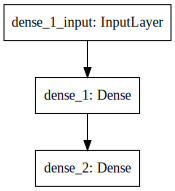

In [90]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import regularizers


np.random.seed(0)

model = Sequential()
model.add(Dense(200, input_dim=44, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(3, activation="sigmoid"))
#model.compile(optimizer=SGD(lr=3), loss='mean_squared_error', metrics=["accuracy"])
model.compile(optimizer=SGD(lr=3), loss='categorical_crossentropy', metrics=["accuracy"])


SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [75]:
hist = model.fit(x_Train.values, y_train0, 
                 epochs=300, batch_size=10000, 
                 validation_data=(x_Test.values, y_test0), 
                 verbose=2)

Train on 121036 samples, validate on 30259 samples
Epoch 1/300
0s - loss: 1.5208 - acc: 0.5082 - val_loss: 1.5052 - val_acc: 0.5483
Epoch 2/300
0s - loss: 1.5101 - acc: 0.5447 - val_loss: 1.4842 - val_acc: 0.5483
Epoch 3/300
0s - loss: 1.4904 - acc: 0.5447 - val_loss: 1.4663 - val_acc: 0.5483
Epoch 4/300
0s - loss: 1.4737 - acc: 0.5447 - val_loss: 1.4509 - val_acc: 0.5483
Epoch 5/300
0s - loss: 1.4593 - acc: 0.5447 - val_loss: 1.4378 - val_acc: 0.5483
Epoch 6/300
0s - loss: 1.4470 - acc: 0.5447 - val_loss: 1.4266 - val_acc: 0.5483
Epoch 7/300
0s - loss: 1.4365 - acc: 0.5447 - val_loss: 1.4170 - val_acc: 0.5483
Epoch 8/300
0s - loss: 1.4276 - acc: 0.5447 - val_loss: 1.4088 - val_acc: 0.5483
Epoch 9/300
0s - loss: 1.4199 - acc: 0.5447 - val_loss: 1.4018 - val_acc: 0.5483
Epoch 10/300
0s - loss: 1.4133 - acc: 0.5447 - val_loss: 1.3958 - val_acc: 0.5483
Epoch 11/300
0s - loss: 1.4077 - acc: 0.5447 - val_loss: 1.3907 - val_acc: 0.5483
Epoch 12/300
0s - loss: 1.4029 - acc: 0.5447 - val_loss:

0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 102/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 103/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 104/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 105/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 106/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 107/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 108/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 109/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 110/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 111/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 112/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 113/300
0s -

0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 201/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 202/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 203/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 204/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 205/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 206/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 207/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 208/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 209/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 210/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 211/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 212/300
0s -

0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483
Epoch 300/300
0s - loss: 1.3746 - acc: 0.5447 - val_loss: 1.3604 - val_acc: 0.5483


In [91]:
list1 = ['people_id','activity_id','date', 'outcome']
act_Train = ResetDataFrame(act_Train, list1)
act_Train = SetTime(act_Train,'date')
act_Train.drop('date',axis = 1,inplace = True)

In [92]:
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,...,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,False,False,True,False,False,False,True,True,False,84


In [93]:
list1 = ['people_id','date','char_38']
people = ResetDataFrame(people, list1)
people = SetTime(people,'date')
people.drop('date',axis = 1,inplace = True)

In [94]:
trainMerge = pd.merge(act_Train,people, on='people_id')
trainMerge.tail()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y,weekday_y,weekend_y
2197286,ppl_99994,act2_4668076,4,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0
2197287,ppl_99994,act2_4743548,4,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0
2197288,ppl_99994,act2_536973,2,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0
2197289,ppl_99994,act2_688656,4,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0
2197290,ppl_99994,act2_715089,2,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0


In [95]:
trainMerge.to_csv('./data/train_merge.csv',index=False)

In [96]:
list1 = ['people_id','activity_id','date', 'outcome']
act_Test = ResetDataFrame(act_Test, list1)
act_Test = SetTime(act_Test,'date')
act_Test.drop('date',axis = 1,inplace = True)

In [97]:
testMerge = pd.merge(act_Test,people, on='people_id')
testMerge.tail()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y,weekday_y,weekend_y
498682,ppl_99997,act2_4367092,2,0,0,0,0,0,0,0,...,0,0,0,0,36,2022,3,12,5,0
498683,ppl_99997,act2_4404220,2,0,0,0,0,0,0,0,...,0,0,0,0,36,2022,3,12,5,0
498684,ppl_99997,act2_448830,2,0,0,0,0,0,0,0,...,0,0,0,0,36,2022,3,12,5,0
498685,ppl_99997,act2_450133,2,0,0,0,0,0,0,0,...,0,0,0,0,36,2022,3,12,5,0
498686,ppl_99997,act2_847967,2,0,0,0,0,0,0,0,...,0,0,0,0,36,2022,3,12,5,0


In [98]:
testMerge.to_csv('./data/test_merge.csv',index=False)

In [127]:
act_id = testMerge['activity_id']
testMergeX = testMerge.drop(['people_id','activity_id'],axis = 1)

In [99]:
trainMerge.tail()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y,weekday_y,weekend_y
2197286,ppl_99994,act2_4668076,4,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0
2197287,ppl_99994,act2_4743548,4,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0
2197288,ppl_99994,act2_536973,2,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0
2197289,ppl_99994,act2_688656,4,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0
2197290,ppl_99994,act2_715089,2,0,0,0,0,0,0,0,...,1,1,1,1,95,2023,1,6,4,0


In [100]:
mergeX = trainMerge.drop(['people_id','activity_id','outcome'],axis = 1)
mergey = trainMerge['outcome']

In [101]:
x_Train, x_Test, y_train, y_test = train_test_split(mergeX, 
                                                   mergey, test_size = 0.2, random_state = 1)

In [102]:
y_train0 = np_utils.to_categorical(y_train,2)
y_test0 = np_utils.to_categorical(y_test, 2)

In [103]:
print (x_Train.shape)
print (x_Test.shape)

(1757832, 60)
(439459, 60)


In [113]:
from keras.layers import Dropout

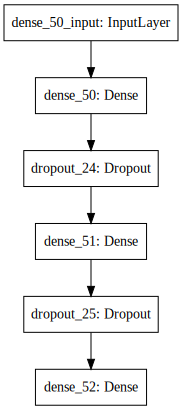

In [175]:
np.random.seed(0)

model = Sequential()
model.add(Dense(500, input_dim=60, activation="sigmoid",kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(0.005)))
model.add(Dropout(0.45))
model.add(Dense(100, activation="sigmoid"))
model.add(Dropout(0.45))
model.add(Dense(2, activation="softmax"))
#model.add(Dense(2, activation="relu"))
#model.add(Dropout(0.2))
#model.add(Dense(2, activation="softmax"))
#model.compile(optimizer=SGD(lr=3), loss='mean_squared_error', metrics=["accuracy"])
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=["accuracy"])


SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
hist = model.fit(x_Train.values, y_train0, 
                 epochs=10, batch_size=550000, 
                 validation_data=(x_Test.values, y_test0), 
                 verbose=2)

Train on 1757832 samples, validate on 439459 samples
Epoch 1/10


In [ ]:
plt.plot(hist.history['loss'])
plt.show()

In [ ]:
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

In [163]:
x = model.predict_classes(testMergeX.values)

497536/498687 [============================>.] - ETA: 0s

In [164]:
x2 = pd.concat([act_id,pd.DataFrame(x)],axis = 1)
x2.rename({0:'outcome'},inplace = True,axis = 1)

In [165]:
x2.to_csv('./submission8.csv',index = False)

In [47]:
import time
import xgboost as xgb
from sklearn.cross_validation import train_test_split

In [105]:
def run(train, test, random_state=0):
    eta = 1.3
    max_depth = 3
    subsample = 0.8
    colsample_bytree = 0.8
    start_time = time.time()
    params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
        "seed": random_state
    }
    num_boost_round = 2
    early_stopping_rounds = 10
    test_size = 0.1
    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train['outcome']
    y_valid = X_valid['outcome']
    X_train = X_train.drop(['people_id','activity_id','outcome'],axis = 1)
    X_valid = X_valid.drop(['people_id','activity_id','outcome'], axis = 1)
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    check = gbm.predict(xgb.DMatrix(X_valid), ntree_limit=gbm.best_iteration+1)
    score = roc_auc_score(y_valid, check)
    print (score)
    testActivityId = test['activity_id']
    test = test.drop(['people_id','activity_id'],axis = 1)
    test_prediction = gbm.predict(xgb.DMatrix(test), ntree_limit=gbm.best_iteration+1)
    out = pd.concat([testActivityId,pd.DataFrame(test_prediction.round())],axis = 1)
    out.rename({0:'outcome'},axis = 1,inplace = True)
    return out,test_prediction

In [106]:
x = run(trainMerge, testMerge)

[0]	train-auc:0.876135	eval-auc:0.875169
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.896448	eval-auc:0.895751
0.895751382685
